![](https://i.ibb.co/4PFKrfw/cover-03.jpg)

## Abstract:

**i. ❓Background:** Employee turnover is the loss of talent in the workforce that can be costly for a company. Uplift modeling is one of several prescriptive methods available in machine learning models that not only predict an outcome but also prescribe a solution. Recent studies are focusing on the conventional predictive models (binary classification) to predict employee turnover rather than uplift modeling.

**ii. 🎯Aim:** In this research, we analyze whether the Uplift Modeling has better performance than the conventional predictive model in solving employee turnover.

**iii. ⚙️Methodology:** Performance comparison between the two methods was carried out by experimentation using two synthetic datasets and one real dataset. XGBoost is used as the machine learning algorithm for both models in this experiment.

**iv. ✔️Results:** After observing the 6 Qini curves, the results show that despite the ETP model yields an average prediction accuracy of 84%; it only yields a success rate of 50% to target the right employee with a retention program on the three datasets. By contrast, the uplift model only yields an average accuracy of 67% but yields a consistent success rate of 100% in targeting the right employee with a retention program.

![](https://i.ibb.co/XJp4Kwh/Uplift-framework-15.jpg)

Four target classes are generated by fitting the treatment status and employee turnover status as visualized in the left part of the image above:
1. Control Non–responders (CN): Employees who have not been treated with the retention program and left. We want to find the persuadables in this group.
2. Control Responders (CR): Employees who have not been treated with the retention program and stay. We want to avoid targeting this group because we do not need to treat them to make them stay, and there is a possibility that some of them are Do-Not-Disturbs.
3. Treated Non–Responders (TN): Employees who have been treated with the retention program but left. We want to avoid treating this group because they will leave if treated, and there is a possibility that some of them are Do-Not-Disturbs that will stay if left untreated.
4. Treated Responders (TR): Employees who have been treated with the retention program and stayed. We also want to find the persuadables in this group.

Therefore, by combining CN with CR and TN with TR will result in C, and T, respectively. Thus by fitting the treated and control group from those four target classes as visualized in the right table will yield four possible theoretical uplift classes (also known as the four quadrants):

1. Do-Not-Disturb (CRTN): Sometimes referred to as sleeping dogs, employees who will be driven away if treated.
2. Lost Causes (CNTN): Employees who will leave whether treated or not.
3. Sure Things (CRTR): Employees who will stay whether treated or not.
4. Persuadables (CNTR): Employees who are willing to leave but will stay if treated. We want to target this group to reduce overall employee turnover in the company.

After predicting the four target classes which are visualized with XGBoost, four probability results are generated. Where P is the probability result, thus uplift score is calculated with LGWUM (Lai's Generalized Weighted Uplift Method) as: 
> ## Uplift Score = P(CN/C)+ P(TR/T) – P(CR/C) – P(TN/T)

# III. Experimental Analysis
The workflow of this project will follow the machine-learning-pipeline below:

![](https://i.ibb.co/mFS1V74/pipeline-english-Artboard-53-01.jpg)

# 1. Setup
First let's set up the environment and datasets

In [1]:
# Import the packages and libraries needed for this project
import matplotlib as mpl, matplotlib.pyplot as plt, \
pandas as pd, seaborn as sns, xgboost as xgb, sklearn as sk
from sklearn.metrics import accuracy_score, \
confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Checking for package version
print("Matplotlib Version", mpl.__version__)
print("Pandas Version", pd.__version__)
print("Xgboost Version", xgb.__version__)
print("Seaborn Version", sns.__version__)
print("Sci-kit learn Version", sk.__version__)

Matplotlib Version 3.2.1
Pandas Version 1.1.1
Xgboost Version 1.2.0
Seaborn Version 0.10.0
Sci-kit learn Version 0.23.2


In [3]:
# Import the three datasets
df_data_1 = pd.read_csv('/kaggle/input/hr-analytics/HR_comma_sep.csv')
df_data_2 = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data_3 = pd.read_csv('/kaggle/input/employee-turnover/turnover.csv', encoding = 'ISO-8859-1')
df_model_1 = df_data_1.copy()
df_model_2 = df_data_2.copy()
df_model_3 = df_data_3.copy()

# 2. Data Exploration

Now we've the datasets ready, let's check for null data.

In [4]:
# Explore dataset 1
df_data_1.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# Explore dataset 2
df_data_2.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
# Explore dataset 3
df_data_3.head(5)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [7]:
# Check for null.
display(df_data_1.isnull().values.any())
display(df_data_2.isnull().values.any())
display(df_data_3.isnull().values.any())

False

False

False

Good, there is no null data.

# 3. Data preprocessing

In [8]:
# Drop unwanted features (i.e. columns) that will be dropped.
drop_2 = ['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18']
df_model_2 = df_model_2.drop(drop_2,axis=1)

print('Deleting unwanted features...')
print(drop_2)
print('✔️Deleted')

Deleting unwanted features...
['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18']
✔️Deleted


In [9]:
# Rename all target features.
df_model_1 = df_model_1.rename(columns={'left': 'churn'})
df_model_2 = df_model_2.rename(columns={'Attrition': 'churn'})
df_model_3 = df_model_3.rename(columns={'event': 'churn'})
print("✔️ Rename target column names to 'churn'")

✔️ Rename target column names to 'churn'


In [10]:
# Rename all treatment features.
df_model_1 = df_model_1.rename(columns={'promotion_last_5years': 'treatment'})
df_model_2 = df_model_2.rename(columns={'OverTime': 'treatment'})
df_model_3 = df_model_3.rename(columns={'coach': 'treatment'})
print("✔️ Rename treatment column names to 'treatment'")

✔️ Rename treatment column names to 'treatment'


In [11]:
print("Explore the unique data in the 'selected features' (for the label encoding):")
string1, string2, string3 = ['salary'], ['churn',
                                         'treatment',
                                         'BusinessTravel'], ['treatment']

print('\nDataset 1:')
for col in string1:
    print(col, df_model_1[col].unique())

print('\nDataset 2:')
for col in string2:
    print(col, df_model_2[col].unique())
    
print('\nDataset 3:')
for col in string3:
    print(col, df_model_3[col].unique())

Explore the unique data in the 'selected features' (for the label encoding):

Dataset 1:
salary ['low' 'medium' 'high']

Dataset 2:
churn ['Yes' 'No']
treatment ['Yes' 'No']
BusinessTravel ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Dataset 3:
treatment ['no' 'yes' 'my head']


In [12]:
# Manually label encode the target (i.e. dependent variable) for dataset 1
df_model_1.salary = df_model_1.salary.map({'low': 0, 'medium': 1, 'high':2})
print("✔️ Label encoding the 'salary' feature in dataset 1")

✔️ Label encoding the 'salary' feature in dataset 1


In [13]:
# Manually label encode the target and identified treatment (i.e. employee retention program) for dataset 2
df_model_2.churn = df_model_2.churn.map({'Yes': 1, 'No': 0})
df_model_2.treatment = df_model_2.treatment.map({'Yes': 0, 'No': 1})
# Declaration BusinessTravel
df_model_2.BusinessTravel = df_model_2.BusinessTravel.map({'Non-Travel': 0,
                                                           'Travel_Rarely': 1,
                                                           'Travel_Frequently':2})
print("✔️ Label encoding the 'churn, treatment, & BusinessTravel' features in dataset 2")

✔️ Label encoding the 'churn, treatment, & BusinessTravel' features in dataset 2


In [14]:
# Manually label encode the target and treatment for dataset 3
df_model_3.treatment = df_model_3.treatment.map({'yes': 0, 'no': 1, 'my head':2})
df_model_3 = df_model_3.loc[df_model_3.treatment <=1].reset_index(drop=True)
print("✔️ Label encoding the 'treatment' feature in dataset 3")

✔️ Label encoding the 'treatment' feature in dataset 3


Secondly, let's turn the rest of the string/object data into integer with the magical get_dummies function (One hot encoding) from Pandas package, so we can feed the data into XGBoost. Moreover, I add another dataframe df_model_inverse that will be useful for later:

In [15]:
# One-Hot Encoding:
df_model_1, df_model_inverse_1 = pd.get_dummies(df_model_1), pd.get_dummies(df_model_1)
df_model_2, df_model_inverse_2 = pd.get_dummies(df_model_2), pd.get_dummies(df_model_2)
df_model_3, df_model_inverse_3 = pd.get_dummies(df_model_3), pd.get_dummies(df_model_3)
print("✔️ One-hot encoding")

✔️ One-hot encoding


Let's check the treatment's correlation to employee turnover:

In [16]:
def correlation_treatment(df:pd.DataFrame):
    """Function to calculate the treatment's correlation
    """
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [17]:
print("✔️Treatment correlation in dataset 1:", correlation_treatment(df_model_1).iloc[0,0])
print("\n✔️Treatment correlation in dataset 2:", correlation_treatment(df_model_2).iloc[0,0])
print("\n✔️Treatment correlation in dataset 3:", correlation_treatment(df_model_3).iloc[0,0])

✔️Treatment correlation in dataset 1: -6.18

✔️Treatment correlation in dataset 2: -24.61

✔️Treatment correlation in dataset 3: -4.0


Good, now all of the treatment features are negatively correlated. For instance, when the treatment in dataset 1 (promotion last 5 years) is true, the employee churn tend to be reduced.

We will use the positive ones later at the end of this project. For now, let's add the four uplift category for each datasets:

In [18]:
def declare_target_class(df:pd.DataFrame):
    """Function for declare the target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

In [19]:
# Add the four target classes
df_model_1, df_model_2, df_model_3 = declare_target_class(df_model_1), \
declare_target_class(df_model_2), declare_target_class(df_model_3)

# 4. Machine Learning Modeling

Finally we're ready to start the machine learning process:

In [20]:
def split_data(df_model:pd.DataFrame):
    """Split data into training data and testing data
    """
    X = df_model.drop(['churn','target_class'],axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def machine_learning(X_train:pd.DataFrame,
                     X_test:pd.DataFrame,
                     y_train:pd.DataFrame,
                     y_test:pd.DataFrame,
                     z_train:pd.DataFrame,
                     z_test:pd.DataFrame):
    """Machine learning process consists of 
    data training, and data testing process (i.e. prediction) with XGBoost (XGB) Algorithm
    """
    # prepare a new DataFrame
    prediction_results = pd.DataFrame(X_test).copy()
    
    
    # train the ETP model
    model_tp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # prediction Process for ETP model 
    prediction_tp \
    = model_tp.predict(X_test.drop('treatment',axis=1))
    probability__tp \
    = model_tp.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_churn'] = prediction_tp
    prediction_results['proba_churn'] = probability__tp[:,1]
    
    
    # train the ETU model
    model_etu \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # prediction Process for ETU model 
    prediction_etu \
    = model_etu.predict(X_test.drop('treatment', axis=1))
    probability__etu \
    = model_etu.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_target_class'] = prediction_etu
    prediction_results['proba_CN'] = probability__etu[:,0] 
    prediction_results['proba_CR'] = probability__etu[:,1] 
    prediction_results['proba_TN'] = probability__etu[:,2] 
    prediction_results['proba_TR'] = probability__etu[:,3]
    prediction_results['score_etu'] = prediction_results.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    
    # add the churn and target class into dataframe as validation data
    prediction_results['churn'] = y_test
    prediction_results['target_class'] = z_test
    return prediction_results


def predict(df_model:pd.DataFrame):
    """Combining data split and machine learning process with XGB
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)
    prediction_results = machine_learning(X_train,
                                          X_test,
                                          y_train,
                                          y_test,
                                          z_train,
                                          z_test)
    print("✔️Prediction succeeded")
    return prediction_results

In [21]:
# Machine Learning Modelling Process
print("Predicting dataset 1 ...")
prediction_results_1 = predict(df_model_1)
print("\nPredicting dataset 2 ...")
prediction_results_2 = predict(df_model_2)
print("\nPredicting dataset 3 ...")
prediction_results_3 = predict(df_model_3)

Predicting dataset 1 ...
✔️Prediction succeeded

Predicting dataset 2 ...
✔️Prediction succeeded

Predicting dataset 3 ...
✔️Prediction succeeded


Prediction results are stored in prediction_results_1, prediction_results_2, and prediction_results_3 for dataset 1, dataset 2, and dataset 3, respectively.

In [22]:
# Uncomment this line below to save the prediction result into an Excel file.
# prediction_results_3.to_excel("output_prediction3.xlsx")  

# 5. Evaluating predictive performance

Now let's evaluate the predictive performance:

In [23]:
def cm_evaluation(df:pd.DataFrame):
    """Confusion matrix evaluation
    """  
    print("===================================")
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df['churn'], df['prediction_churn'])
    df_confusion_etp = pd.DataFrame(confusion_etp, columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_confusion_etp)
    
    print("-----------------------------------")
    
    print("2. ETU's confusion matrix result:")   
    confusion_etu = multilabel_confusion_matrix(df['target_class'], df['prediction_target_class'])
    print("a. CN's confusion matrix:")  
    df_cn = pd.DataFrame(confusion_etu[0], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cn)
    print("b. CR's confusion matrix:") 
    df_cr = pd.DataFrame(confusion_etu[1], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cr) 
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(confusion_etu[2], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tn) 
    print("d. TR's confusion matrix:") 
    df_tr = pd.DataFrame(confusion_etu[3], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tr)
    
    print("===================================")

In [Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), the True Positive and False Negative are the amount of successful predictions and the True Negative and False Positive are the amount of failed predictions. Therefore, let's generate the confusion matrices:

In [24]:
# Confusion Matrix Evaluation
print("✔️Dataset 1")
cm_evaluation(prediction_results_1)
print("\n\n✔️Dataset 2")
cm_evaluation(prediction_results_2)
print("\n\n✔️Dataset 3")
cm_evaluation(prediction_results_3)

✔️Dataset 1
1. ETP's confusion matrix result:
              Predicted True  Predicted False
Actual True             3407               29
Actual False              38             1026
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
              Predicted True  Predicted False
Actual True             3425               18
Actual False              41             1016
b. CR's confusion matrix:
              Predicted True  Predicted False
Actual True             1065               88
Actual False              22             3325
c. TN's confusion matrix:
              Predicted True  Predicted False
Actual True             4493                0
Actual False               0                7
d. TR's confusion matrix:
              Predicted True  Predicted False
Actual True             4407                4
Actual False              47               42


✔️Dataset 2
1. ETP's confusion matrix result:
              Predicted True  Predicted Fa

Now, let's calculate the accuracy result:

In [25]:
def accuracy_evaluation(df:pd.DataFrame):
    """Accuracy evaluation
    """
    akurasi_cp = accuracy_score(df['churn'],
                                df['prediction_churn'])
    print('✔️ETP model accuracy: %.2f%%' % (akurasi_cp * 100.0))
    
    
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediction_target_class'])
    print('✔️ETU model accuracy: %.2f%%' % (akurasi_uplift * 100.0))

In [26]:
# Accuracy Evaluation Process.
print("Dataset 1")
accuracy_evaluation(prediction_results_1)
print("\nDataset 2")
accuracy_evaluation(prediction_results_2)
print("\nDataset 3")
accuracy_evaluation(prediction_results_3)

Dataset 1
✔️ETP model accuracy: 98.51%
✔️ETU model accuracy: 97.56%

Dataset 2
✔️ETP model accuracy: 85.71%
✔️ETU model accuracy: 62.81%

Dataset 3
✔️ETP model accuracy: 63.67%
✔️ETU model accuracy: 57.96%


Wow, seems like ETP models are much better than ETU models in terms of prediction accuracy. That makes sense anyway, because ETP models only predict two possible outcomes (The employee is turnover or stay), where ETU models predict four possible outcomes (Persuadables, Sure Things, Lost Causes, and Sleeping Dogs/Do-not-disturbs). But will ETP will also have a better performance in solving the employee turnover (prescriptive performance)? Let's find out.

# 6. Evaluating prescriptive performance

Now let's use the prediction results to solve the problem. As explained before, for ETP model employees are ranked by their turnover probability. Employees with the highest turnover probability will be targeted with a retention campaign (the treatment features declared before). On the other side, the ETU models are ranked by its uplift score with LGWUM's formulation.

In [27]:
def sorting_data(df:pd.DataFrame):
    """Function to sort data
    """
    # Set up new DataFrames for ETP model and ETU model
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    
    
    # Add quantiles
    df_c['n'] = df.proba_churn.rank(pct=True, ascending=False)
    df_u['n'] = df.score_etu.rank(pct=True, ascending=False)
    df_c['score'] = df['proba_churn']
    df_u['score'] = df['score_etu']
    
    
    # Ranking the data by deciles
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Calculate the C, T, CR, and TR
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    

    # Calculate & add the qini value into the Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    qini_coef= df['uplift'].sum(skipna = True) - df['random'].sum(skipna = True)
    
    # Print the Qini coefficient
    print('✔️Qini coefficient = {} {}'.format(round(qini_coef, 2), '%'))
    
    # Add q0 into the Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini


def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df_u['model'] = 'ETU'
    df_c['model'] = 'ETP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot the qini curve
    """
    print('\nPlotting the qini curve...')
    
    # Define the data that will be plotted
    order = ['ETU','ETP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    
    
    # Additional plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    print('✔️Successfully plot the qini curve')
    return ax


def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_c, df_u = sorting_data(prediction_results)
    print('ETP model (previous model):')
    qini_c = calculating_qini(df_c)
    print('\nETU model (our proposed model):')
    qini_u = calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini

# Which model is successful or failed?

### 🔢Quantitative measurement:
Now let's calculate the Qini coefficient to measure which model is successful and failed.The higher the coefficient is, indicating a better benefit (in this case, the benefit is preventing employee turnover).But in this project we won't find which model is better or not, we just want to know which one is more reliable (i.e. consistently returning a good result). A successful model has a Qini coefficient above 0 (Give a benefit).

### 📈Qualitative measurement:
Another method to measure the performance qualitatively is by measuring the Qini curve (the red or blue line) in comparison with the random curve (the grey line). The higher the uplift value is and the smaller the proportion is, indicating a good performance. But again, in this project we just want to know which model yields a good result consistently.

ETP model (previous model):
✔️Qini coefficient = -44.35 %

ETU model (our proposed model):
✔️Qini coefficient = 765.81 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

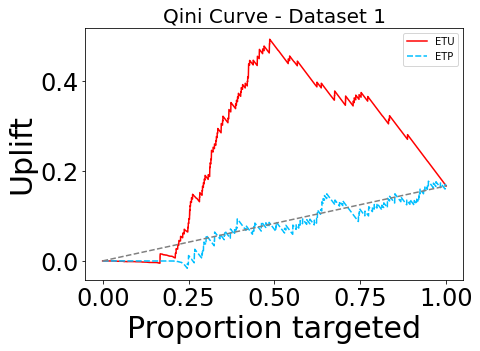

In [28]:
# Qini evaluation results for DataSet 1 with negative treatment correlation
ax, qini_1 = evaluation_qini(prediction_results_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)


# save into pdf:
# plt.savefig('qini_1_n.pdf', bbox_inches='tight')

The Qini curve above shows that the ETU has a better uplift value than the random model. The random model is a straight line from 0 to 100% proportion targeted, this may  indicate the value of the uplift without using any model. By contrast, the ETP model failed to shows a good result above the random mode, therefore we could say that in this case ETP model failed to target the right employees.

Moreover, the Qini coefficient is just the Gini coefficient version of Qini to compare A Model's Qini curve with the random model (i.e. without model). A positive Qini coefficient indicates that the model has succeeded to give a significant benefit.

ETP model (previous model):
✔️Qini coefficient = 35.91 %

ETU model (our proposed model):
✔️Qini coefficient = 23.99 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 2')

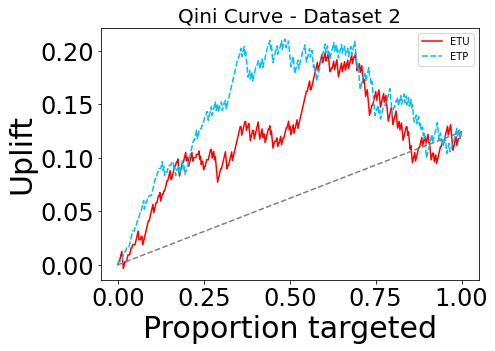

In [29]:
# Qini evaluation results for DataSet 2 with negative treatment correlation
ax, qini_2 = evaluation_qini(prediction_results_2)
plt.title('Qini Curve - Dataset 2',fontsize=20)


# save into pdf:
# plt.savefig('qini_2_n.pdf', bbox_inches='tight'

Well, now the ETP model is catching up and give a good result.

ETP model (previous model):
✔️Qini coefficient = -12.92 %

ETU model (our proposed model):
✔️Qini coefficient = 20.66 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 3')

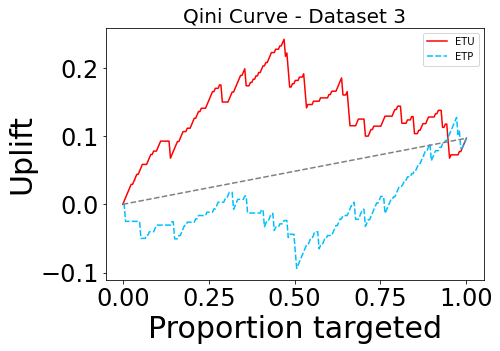

In [30]:
# Qini evaluation results for DataSet 3 with negative treatment correlation
ax, qini_3 = evaluation_qini(prediction_results_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)


# save into pdf:
# plt.savefig('qini_3_n.pdf', bbox_inches='tight')

In the Qini curve above, the ETP model even gives a worse result than not using any model (random model).

So far the success result are: ETU = 3 and ETP = 1.

Furthermore, now we can use the df_model_inverse dataframes we prepared before, we will inverse the value (from 0 to 1, and 1 to 0):

In [31]:
# The process to inverse treatment's parameter
# Thus also inverse the treatment's correlation from negative to positive
df_model_inverse_1.treatment = df_model_inverse_1.treatment.replace({0: 1, 1: 0})
df_model_inverse_2.treatment = df_model_inverse_2.treatment.replace({0: 1, 1: 0})
df_model_inverse_3.treatment = df_model_inverse_3.treatment.replace({0: 1, 1: 0})

In [32]:
# Recalculate the treatment correlation
print("✔️Treatment correlation in dataset 1 (inverted):", correlation_treatment(df_model_inverse_1).iloc[0,0])
print("\n✔️Treatment correlation in dataset 2 (inverted):", correlation_treatment(df_model_inverse_2).iloc[0,0])
print("\n✔️Treatment correlation in dataset 3 (inverted):", correlation_treatment(df_model_inverse_3).iloc[0,0])

✔️Treatment correlation in dataset 1 (inverted): 6.18

✔️Treatment correlation in dataset 2 (inverted): 24.61

✔️Treatment correlation in dataset 3 (inverted): 4.0


Good, now the treatment features are positively correlated with employee turnover. This means, if we target the employees with this treatment, it's more likely that the employee turnover rate will be increased. So it'll be wise to use this treatment carefully. Okay, now let's repeat the prediction procedure once again:

In [33]:
# Add the target class feature to all three datasets
df_model_inverse_1, df_model_inverse_2, df_model_inverse_3 = declare_target_class(df_model_inverse_1), \
declare_target_class(df_model_inverse_2), declare_target_class(df_model_inverse_3)

In [34]:
# Do the prediction process once more time
prediction_results_inverse_1 = predict(df_model_inverse_1)
prediction_results_inverse_2 = predict(df_model_inverse_2)
prediction_results_inverse_3 = predict(df_model_inverse_3)

✔️Prediction succeeded
✔️Prediction succeeded
✔️Prediction succeeded


ETP model (previous model):
✔️Qini coefficient = 302.03 %

ETU model (our proposed model):
✔️Qini coefficient = 720.47 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

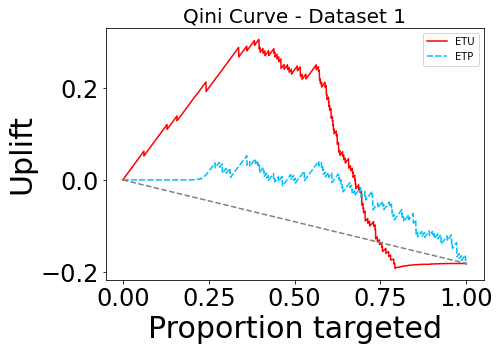

In [35]:
# Qini evaluation results for DataSet 1 with positive treatment correlation
ax, qini_inverse_1 = evaluation_qini(prediction_results_inverse_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)


# save into pdf:
# plt.savefig('qini_1_p.pdf', bbox_inches='tight')

The Qini curve above shows that ETP and ETU are succeeded.

ETP model (previous model):
✔️Qini coefficient = -41.58 %

ETU model (our proposed model):
✔️Qini coefficient = 18.91 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 2')

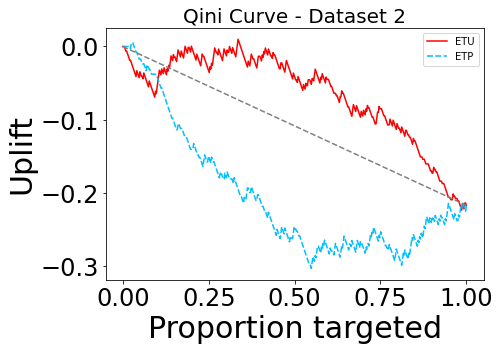

In [36]:
# qini evaluation results for DataSet 2 with positive treatment correlation
ax, qini_inverse_2 = evaluation_qini(prediction_results_inverse_2)
plt.title('Qini Curve - Dataset 2',fontsize=20)


# save into pdf:
# plt.savefig('qini_2_p.pdf', bbox_inches='tight')

The Qini curve above shows that ETP is failed.

ETP model (previous model):
✔️Qini coefficient = 13.0 %

ETU model (our proposed model):
✔️Qini coefficient = 14.17 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 3')

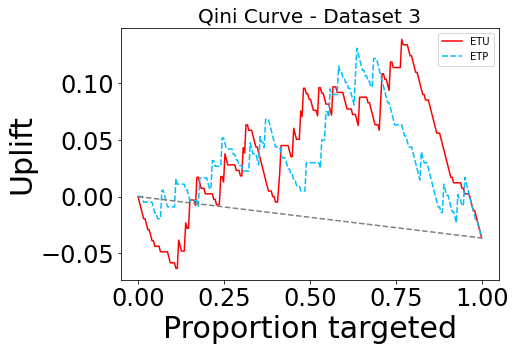

In [37]:
# Qini evaluation results for DataSet 3 with positive treatment correlation
ax, qini_inverse_3 = evaluation_qini(prediction_results_inverse_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)


# save into pdf:
# plt.savefig('qini_3_p.pdf', bbox_inches='tight')

The last Qini curve above shows that both Employee Turnover Uplift (ETU) and Employee Turnover Prediction (ETP) are succeeded.

# Conclusion
Employees with a high [turnover](https://en.wikipedia.org/wiki/Turnover_employment) risk do not necessarily need to be targeted with a retention program. The ETP model tends to target the wrong type of employees (e.g. Do-not-disturbs employees) that will leave the company if targeted and could be [costly](https://builtin.com/recruiting/cost-of-turnover) for the company/employeers. On the other side, the ETU model tends to target the right employees (Persuadables) and prevent unnecessary costs. The Qini curves show that the ETU model yields better uplift value than the ETP model in overall. In other words, the ETU model is more effective as a prescriptive analytics model than the ETP model.

In other words, despite the low prediction accuracy, the Uplift Modeling yields better results than the conventional Churn Prediction Model.